In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima import model_selection

from get_forex_data import get_daily_data, get_small_frequencies

from plot import plot_basic_close, pred_vs_real_plot

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
PAIR = 'USDJPY'
START = '2023-01-01'
END = '2023-09-09'

## Fetch daily data

In [4]:
df_daily = get_daily_data(PAIR, START, END)

df_daily.tail()

# dataframe to join the prediction table at the end
original_data = df_daily.copy().reset_index(names='date')

original_data['tag'] = 'historical'

original_data = original_data[['date','Adj Close','tag']]

# slice the last two weeks
original_data = original_data.tail(14)

original_data.head()

[*********************100%%**********************]  1 of 1 completed


,date,Adj Close,tag
166,2023-08-22,146.238007,historical
167,2023-08-23,145.763000,historical
168,2023-08-24,144.673004,historical
169,2023-08-25,146.067001,historical
170,2023-08-28,146.531006,historical


## Plot the close price

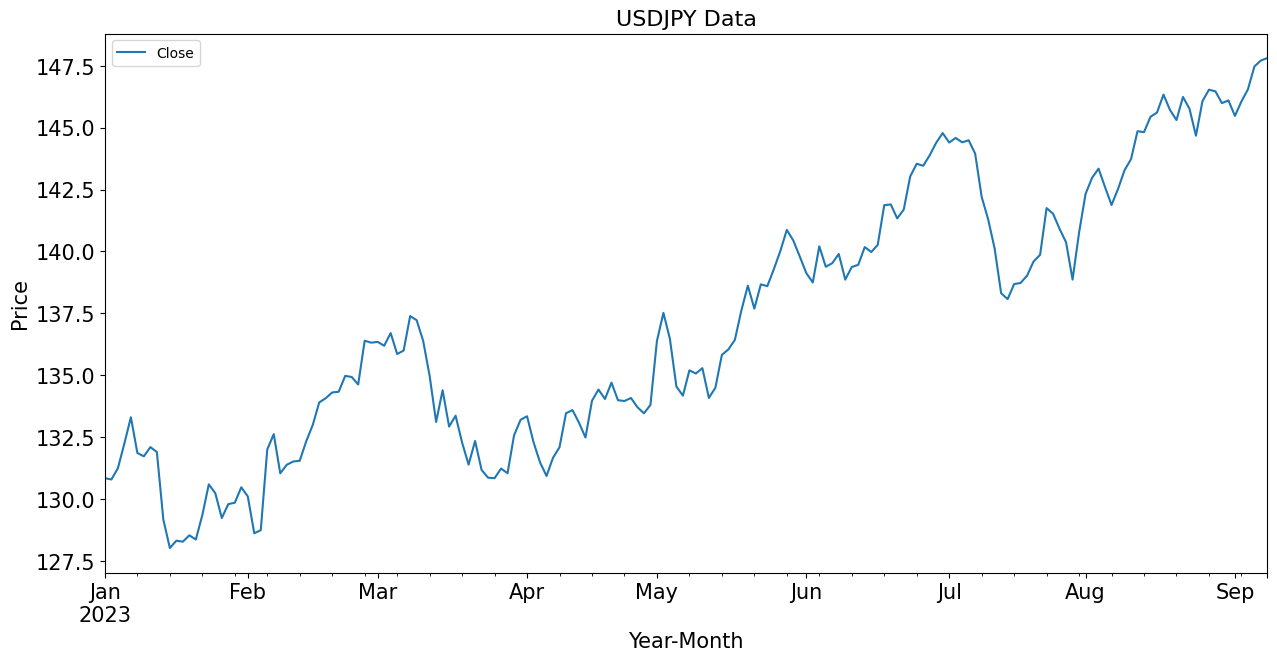

In [5]:
plot_basic_close((15,7), df_daily, PAIR)    

## Get Hourly Data

In [6]:
df_hourly = get_small_frequencies(PAIR, period='30d', interval='1h')
df_hourly.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-08 17:00:00+01:00,147.699997,147.778000,147.658005,147.766006,147.766006,0
2023-09-08 18:00:00+01:00,147.764008,147.778000,147.695999,147.731995,147.731995,0
2023-09-08 19:00:00+01:00,147.733002,147.835007,147.703995,147.822006,147.822006,0
2023-09-08 20:00:00+01:00,147.822998,147.869995,147.804993,147.848999,147.848999,0
2023-09-08 21:00:00+01:00,147.845001,147.858994,147.746002,147.809998,147.809998,0


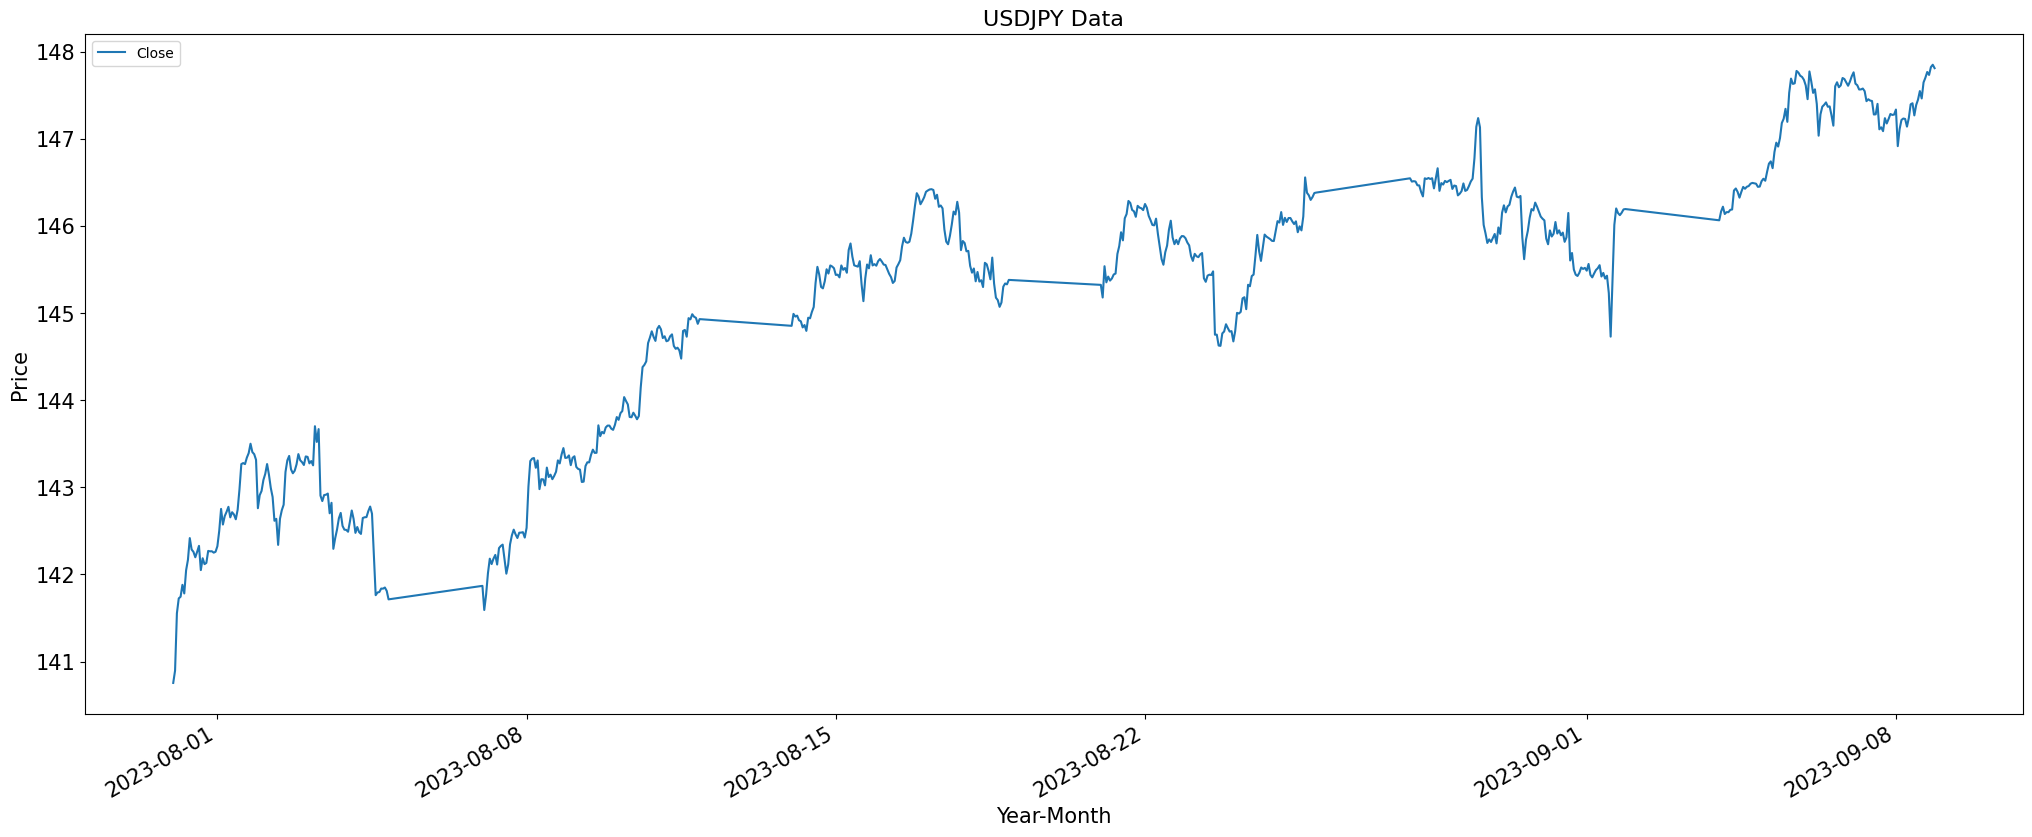

In [7]:
plot_basic_close((25,10), df_hourly, PAIR)   

## Daily Predicion

In [8]:
y = df_daily['Adj Close']

In [9]:

est = pm.ARIMA(order=(1, 1, 2),
               seasonal_order=(0, 1, 1, 12),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=50, step=5, h=5)
validation = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [10]:
x_axis = np.arange(y.shape[0])
n_test = validation.shape[0]

In [11]:
validation.shape[0]

130

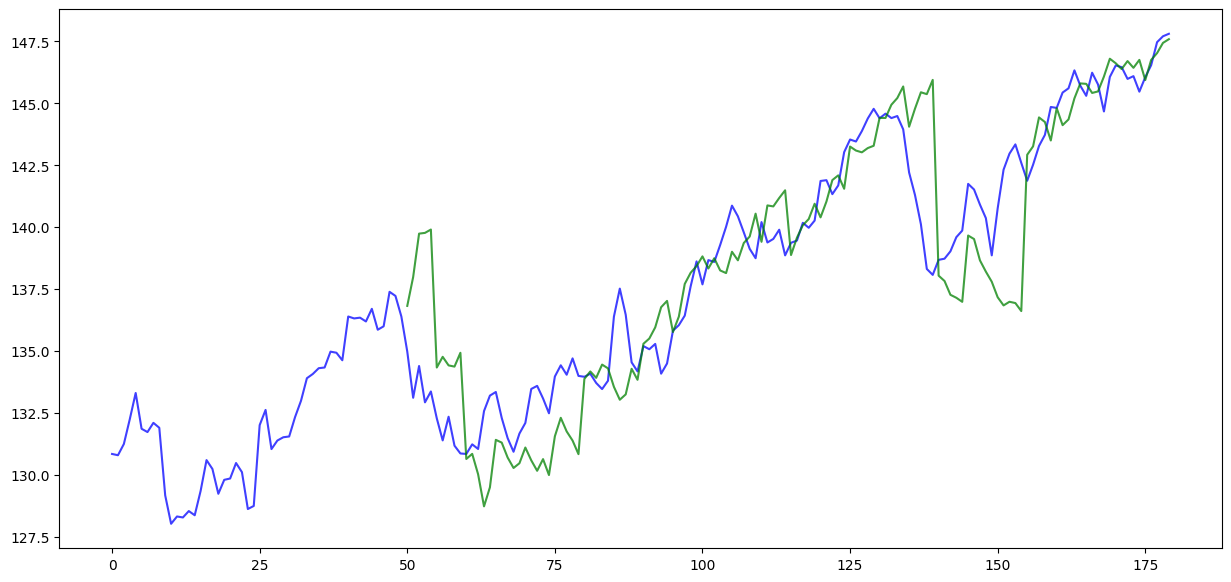

In [12]:
from plot import pred_vs_real_plot
pred_vs_real_plot(df_daily, PAIR , x_axis, y, validation, n_test)    

## Predict the next two weeks

In [13]:
predictions = est.fit(y).predict()

In [16]:
predictions = predictions.to_frame(name='Adj Close').reset_index(names='date')

predictions['tag'] = 'prediction'

all_df = pd.concat([predictions, original_data]).sort_values(by='date')




AttributeError: 'DataFrame' object has no attribute 'to_frame'

<Axes: xlabel='date', ylabel='Adj Close'>

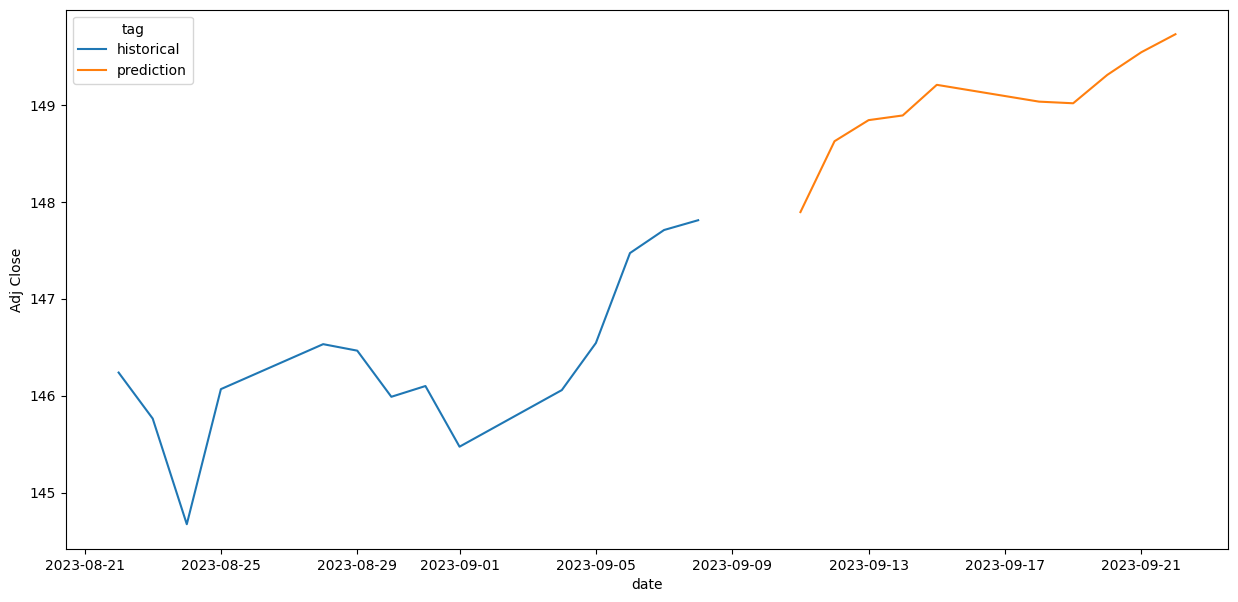

In [15]:
import seaborn as sns
plt.figure(figsize=(15,7))

sns.lineplot(x = 'date', y = 'Adj Close', data = all_df,  hue='tag') 